In [1]:
# Import Yahoo Finance API
import yfinance as yf

# Import backtesting utils
import backtest_tools.portfolio_tools as backtest

# Import utils
import numpy as np
import pandas as pd
from pandas.tseries.offsets import BDay
import datetime as dt

import matplotlib.pyplot as plt
import matplotlib.ticker as mtick

In [27]:
# Get portfolio weights from csv
mvo_weights = pd.read_csv(r'portfolio_reports_2-7-23/mvo_weights_2-7-23.csv').set_index('Date')
mvo_weights = mvo_weights.iloc[-1]

tickers = mvo_weights.index
returns = pd.DataFrame()

for ticker in tickers:

    # Get trailing month's worth of stock prices
    # prices = yf.download(ticker, start=dt.date.today()-BDay(20*12*5), end=dt.date.today())['Adj Close']
    prices = yf.download(ticker, start=dt.date.today()-BDay(252*23), end=dt.date.today())['Adj Close']

    # Get raw asset returns
    raw_rets = prices.pct_change()
    raw_rets = raw_rets.rename(ticker)
    returns = pd.concat([returns, raw_rets], axis=1)

raw_returns = returns
# mvo_weights = backtest.mvo(hist_returns=raw_returns, expected_returns=raw_returns.tail(20*12*5).mean(), target_vol=.01, max_position_weight=2, net_exposure = 1, market_bias=0)
mvo_weights = backtest.mvo(hist_returns=raw_returns, expected_returns=raw_returns.mean(), target_vol=.01, max_position_weight=2, net_exposure = 1, market_bias=0)
weighted_returns = pd.Series((raw_returns*mvo_weights).sum(1), name='TAMID')

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

0.1520106737198881

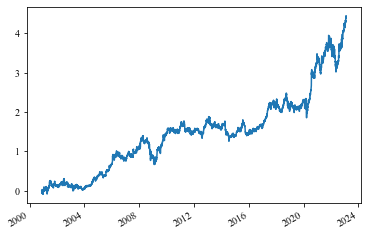

In [28]:
backtest.cumulative_returns(weighted_returns).plot()
weighted_returns.std()*252**.5

Get performance summary and format

In [29]:
# Initialize portfolio performance pd.DataFrame
portfolio_performance = pd.DataFrame()

# Iterate through raw stock returns
for ticker, returns in raw_returns.items():
    # Scale returns to default vol (10%) to ensure direct comparison of CAGR and other relevant values
    returns = backtest.scale_vol(returns).dropna()
    # Get performance summary
    ticker_performance = backtest.performance_summary(returns)
    ticker_performance.name = ticker
    # Append to aggregate pd.DataFrame
    portfolio_performance = pd.concat([portfolio_performance, ticker_performance], axis=1)

# Add performance for TAMID portfolio to aggregate performance pd.DataFrame
portfolio_performance['TAMID'] = backtest.performance_summary(backtest.scale_vol(weighted_returns))

In [30]:
# Format
portfolio_performance = portfolio_performance.T.sort_values(by=['CAGR', 'Sharpe Ratio', 'Drift Adjusted Sharpe Ratio'], ascending=False)
portfolio_performance = portfolio_performance[['Sharpe Ratio', 'Drift Adjusted Sharpe Ratio', 'CAGR', 'Skew', 'Kurtosis', 'CVaR - Laplace', 'Max Drawdown']]
# Add MVO weights as a column
portfolio_performance['Portfolio Weights'] = mvo_weights
portfolio_performance.index.name = 'Portfolio Holdings'
portfolio_performance = np.round(portfolio_performance, 2)
portfolio_performance

,Sharpe Ratio,Drift Adjusted Sharpe Ratio,CAGR,Skew,Kurtosis,CVaR - Laplace,Max Drawdown,Portfolio Weights
Portfolio Holdings,,,,,,,,
NEE,0.68,0.02,0.07,0.31,15.04,-0.03,-0.24,-0.00
ISRG,0.65,0.07,0.06,1.07,17.38,-0.03,-0.22,0.22
EPD,0.58,0.02,0.05,0.22,22.19,-0.03,-0.26,-0.00
TAMID,0.58,0.02,0.05,0.83,13.50,-0.03,-0.21,NaN
ED,0.55,0.04,0.05,0.25,20.53,-0.03,-0.17,-0.14
FISV,0.54,0.02,0.05,0.09,11.16,-0.03,-0.21,-0.00
FTAI,0.53,0.02,0.05,0.86,25.70,-0.03,-0.24,0.05
TSM,0.54,0.01,0.05,0.45,8.98,-0.03,-0.26,0.08
PLYM,0.46,0.02,0.04,-0.41,16.73,-0.03,-0.20,0.00


Save performance table to excel

In [31]:
portfolio_performance.to_clipboard() # don't use to pd.to_excel since it will not maintain special formatting for newsletter

Get trailing 1-week metrics

In [32]:
# Initialize portfolio performance pd.DataFrame
portfolio_performance = pd.DataFrame()

# Iterate through raw stock returns
for ticker, returns in raw_returns.items():
    # Scale returns to default vol (10%) to ensure direct comparison of CAGR and other relevant values
    returns = backtest.scale_vol(returns.tail(20))
    # Get performance summary
    ticker_performance = backtest.performance_summary(returns)
    ticker_performance.name = ticker
    # Append to aggregate pd.DataFrame
    portfolio_performance = pd.concat([portfolio_performance, ticker_performance], axis=1)

# Add performance for TAMID portfolio to aggregate performance pd.DataFrame
portfolio_performance['TAMID'] = backtest.performance_summary(backtest.scale_vol(weighted_returns.tail(20)))

# Format
portfolio_performance = portfolio_performance.T.sort_values(by=['CAGR', 'Sharpe Ratio', 'Drift Adjusted Sharpe Ratio'], ascending=False)
portfolio_performance = portfolio_performance[['Sharpe Ratio', 'Drift Adjusted Sharpe Ratio', 'CAGR', 'Skew', 'Kurtosis', 'CVaR - Laplace', 'Max Drawdown']]
# Add MVO weights as a column
portfolio_performance['Portfolio Weights'] = mvo_weights
portfolio_performance.index.name = 'Portfolio Holdings'
portfolio_performance = np.round(portfolio_performance, 2)
portfolio_performance

,Sharpe Ratio,Drift Adjusted Sharpe Ratio,CAGR,Skew,Kurtosis,CVaR - Laplace,Max Drawdown,Portfolio Weights
Portfolio Holdings,,,,,,,,
ACLS,8.62,5.98,1.01,-0.45,2.20,-0.03,-0.01,0.11
PLYM,6.39,5.65,0.79,0.50,2.78,-0.03,-0.01,0.00
TAMID,5.40,2.64,0.68,0.39,2.98,-0.03,-0.01,NaN
TDOC,5.60,2.51,0.62,-0.59,1.89,-0.03,-0.02,0.05
TSM,5.57,1.32,0.58,0.55,2.90,-0.03,-0.01,0.08
DAL,4.58,0.61,0.43,-0.02,3.28,-0.03,-0.01,0.00
EPD,4.69,0.99,0.42,-0.90,3.24,-0.03,-0.02,-0.00
FTAI,5.91,2.06,0.40,0.81,4.34,-0.03,-0.01,0.05
FISV,3.12,3.43,0.37,-0.02,1.87,-0.03,-0.01,-0.00


Get SPY returns and run Alpha Regression (TAMID ~ SPY)

In [33]:
# Get trailing 6-month's worth of stock prices
# spy_prices = yf.download('SPY', start=dt.date.today()-BDay(20*12*5), end=dt.date.today())['Adj Close']
spy_prices = yf.download('SPY', start=dt.date.today()-BDay(252*23), end=dt.date.today())['Adj Close']

# Get raw asset returns
spy_returns = spy_prices.pct_change().dropna()
spy_returns = spy_returns.rename('SPY')

alpha_regression = np.round(backtest.alpha_regression(weighted_returns, spy_returns), 3)

alpha_regression.to_excel(r'portfolio_reports_2-7-23/alpha_regression.xlsx')

[*********************100%***********************]  1 of 1 completed


In [34]:
alpha_regression

,TAMID ~ SPY
Strategy Alpha,0.085
Alpha T-Stat,2.632
Strategy Beta,0.033
Beta T-Stat,3.236


Scale TAMID & SPY volatility for direct comparison

In [35]:
spy_returns = backtest.scale_vol(spy_returns, target_vol=.2)
weighted_returns = backtest.scale_vol(weighted_returns, target_vol=.2)

Plot returns + OLS

In [36]:
import statsmodels.api as sm

# Construct OLS regression of portfolio returns over time

# Get numerical values of time as exog variable
date_index = np.arange(weighted_returns.index.size)
exog = sm.add_constant(date_index)  

# Build model
model = sm.OLS(backtest.cumulative_returns(weighted_returns), exog)
portfolio_regression = model.fit()

# Get regression params
alpha = portfolio_regression.params[0]
beta = portfolio_regression.params[1]

# Compute best fit line and format
reg_pred = date_index * beta + alpha
reg_pred = pd.Series(reg_pred, index=weighted_returns.index, name='TAMID OLS Regression')

Compute rolling metrics and plot

In [37]:
# Get rolling month's SR
rolling_spy_sr = backtest.sharpe_ratio(spy_returns.rolling(20))
rolling_tamid_sr = backtest.sharpe_ratio(weighted_returns.rolling(20))

# Get rolling month's CAGR -- have to do it this weird way because of the underlying functions' inability to handle rolling values
rolling_spy_cagr = {}
rolling_tamid_cagr = {}
for i, date in enumerate(weighted_returns.iloc[20:].index):
    # SPY
    tmp_spy_returns = spy_returns.iloc[20+i-20:20+i-1]
    rolling_spy_cagr[date] = backtest.cagr(tmp_spy_returns)
    # TAMID
    tmp_tamid_returns = weighted_returns.iloc[20+i-20:20+i-1]
    rolling_tamid_cagr[date] = backtest.cagr(tmp_tamid_returns)

rolling_spy_cagr = pd.Series(rolling_spy_cagr)
rolling_tamid_cagr = pd.Series(rolling_tamid_cagr)


import backtest_tools.risk_analysis as risk_analysis
# Get rolling month's Max DD
rolling_spy_max_dd = {}
rolling_tamid_max_dd = {}

for i, date in enumerate(weighted_returns.iloc[20:].index):

    # SPY
    tmp_spy_returns = spy_returns.iloc[20+i-20:20+i-1]
    try:
        rolling_spy_max_dd[date] = risk_analysis.get_max_n_drawdowns(tmp_spy_returns, N=1, plot=False).iloc[0]
    except:
        rolling_spy_max_dd[date] = 0

    # TAMID
    tmp_tamid_returns = weighted_returns.iloc[20+i-20:20+i-1]
    try:
        rolling_tamid_max_dd[date] = risk_analysis.get_max_n_drawdowns(tmp_tamid_returns, N=1, plot=False).iloc[0]
    except:
        rolling_tamid_max_dd[date] = 0

rolling_spy_max_dd = pd.Series(rolling_spy_max_dd)
rolling_tamid_max_dd = pd.Series(rolling_tamid_max_dd)

Genreate all relevant subplots for a uniform format

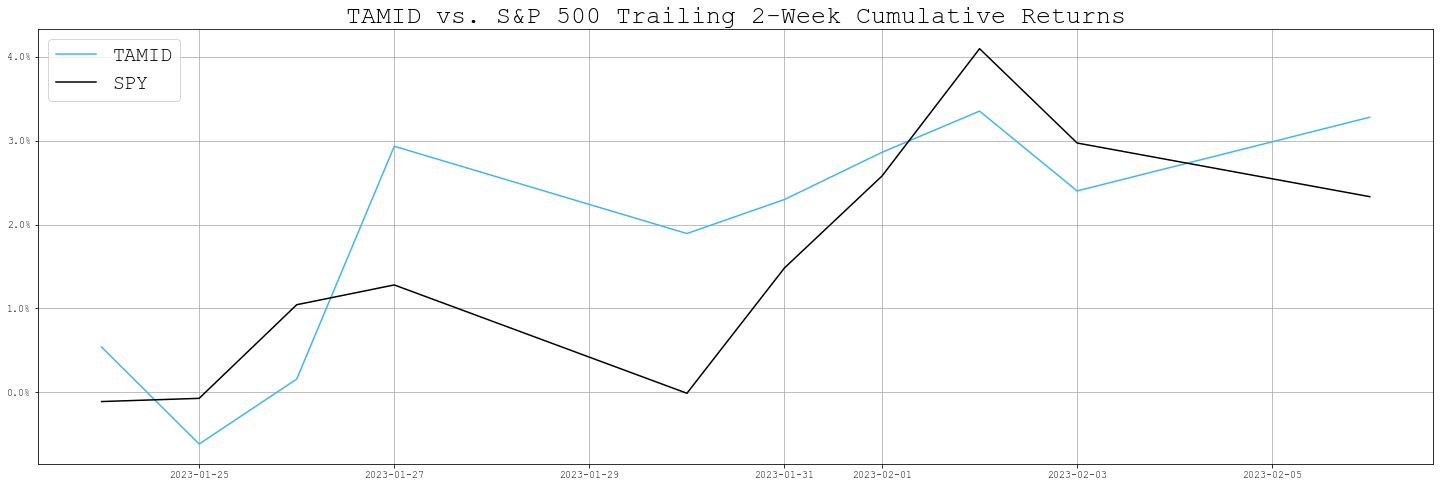

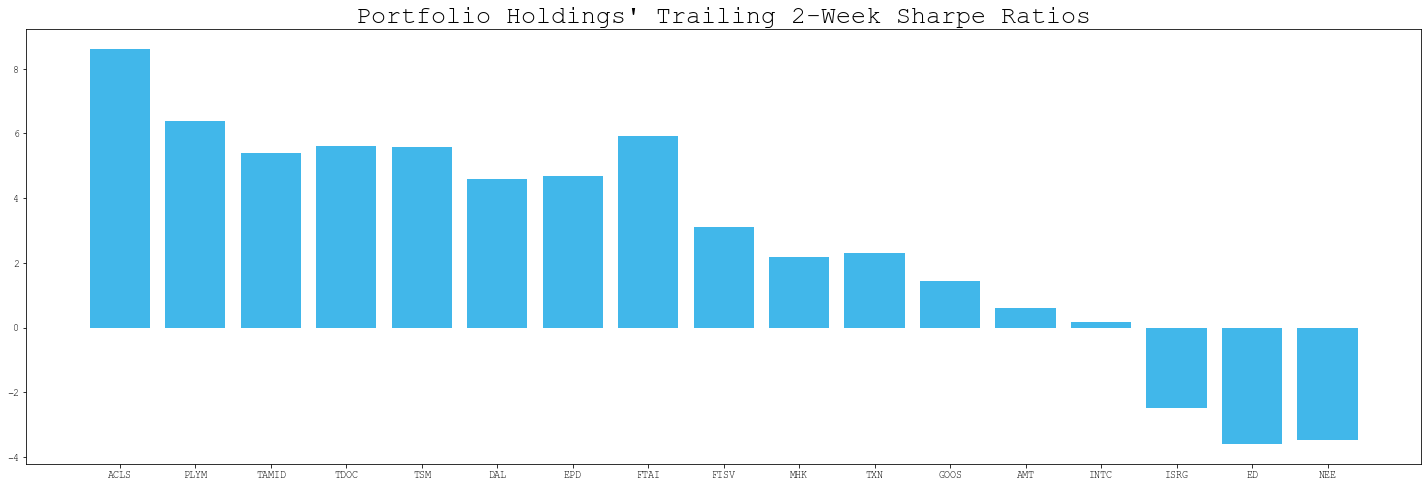

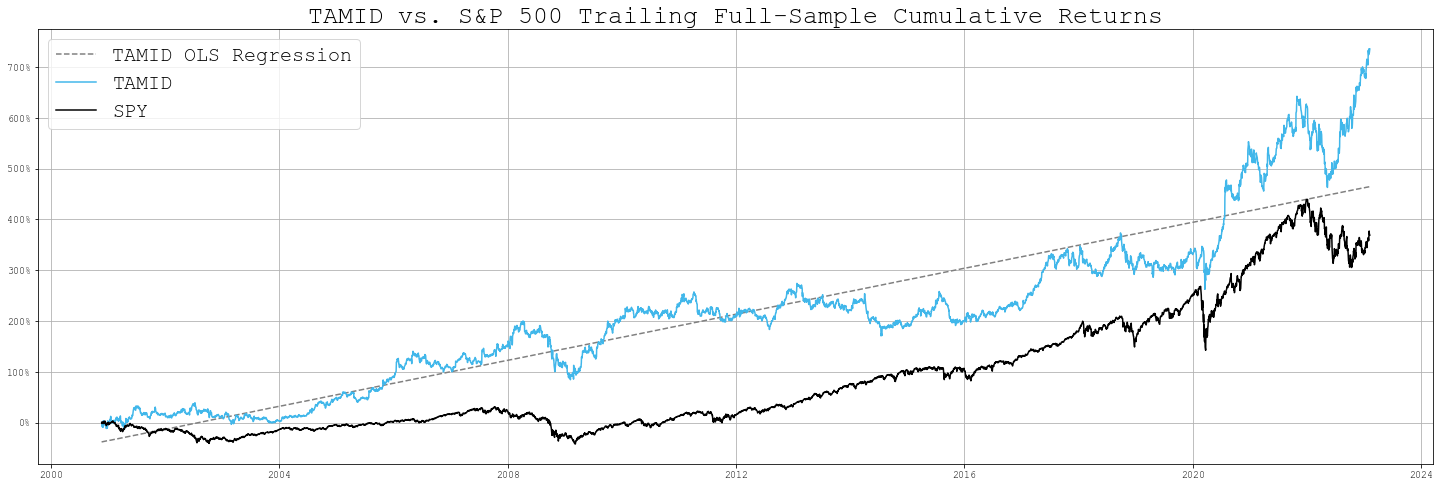

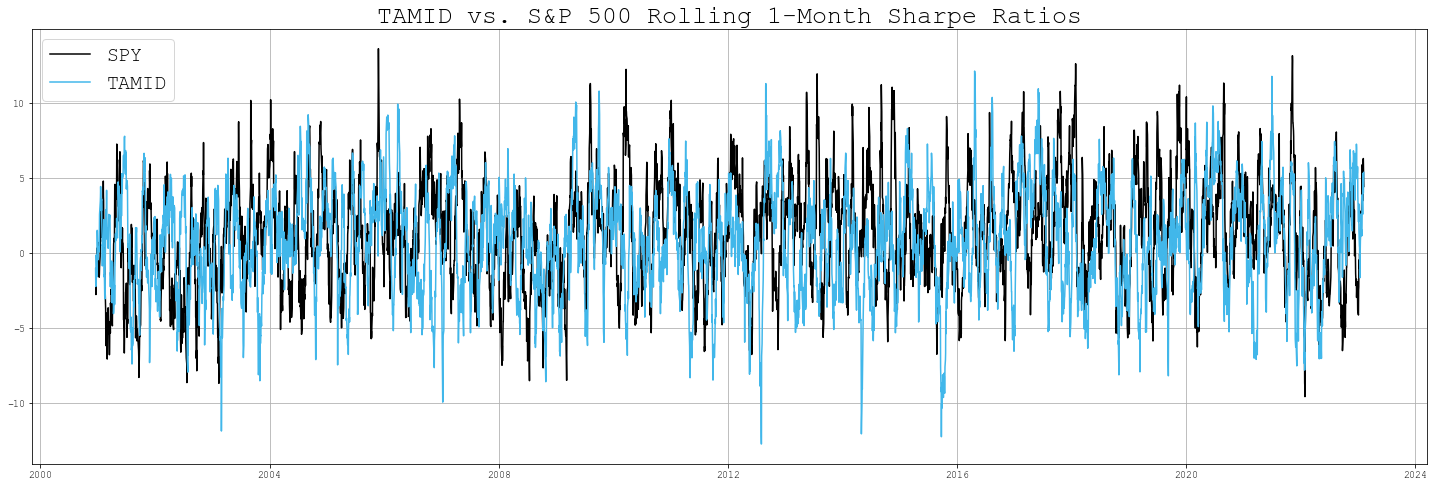

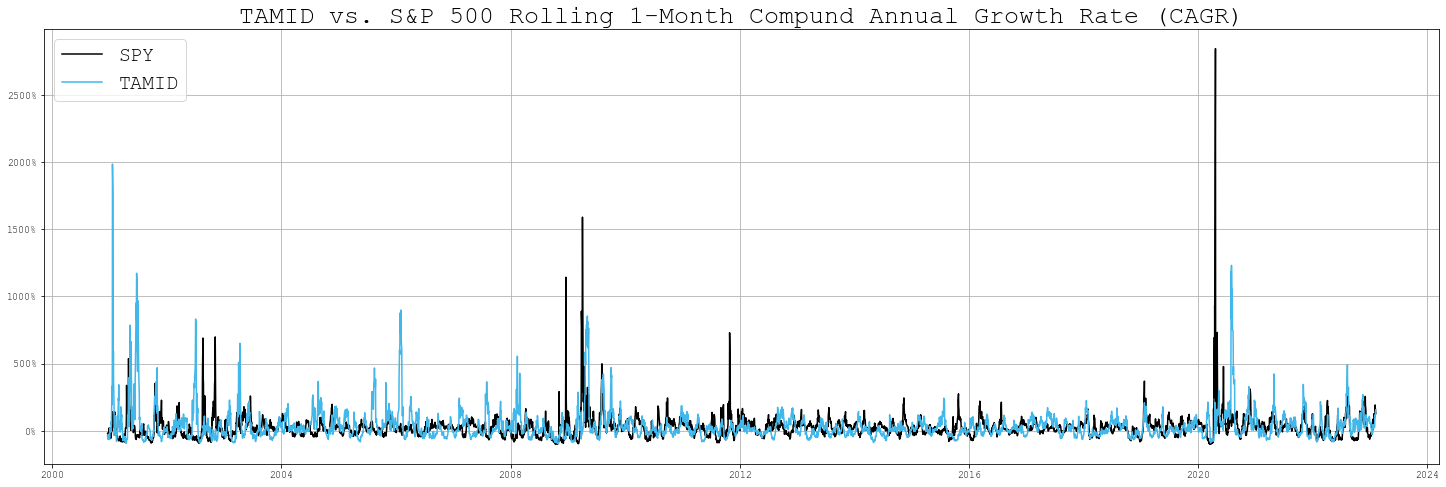

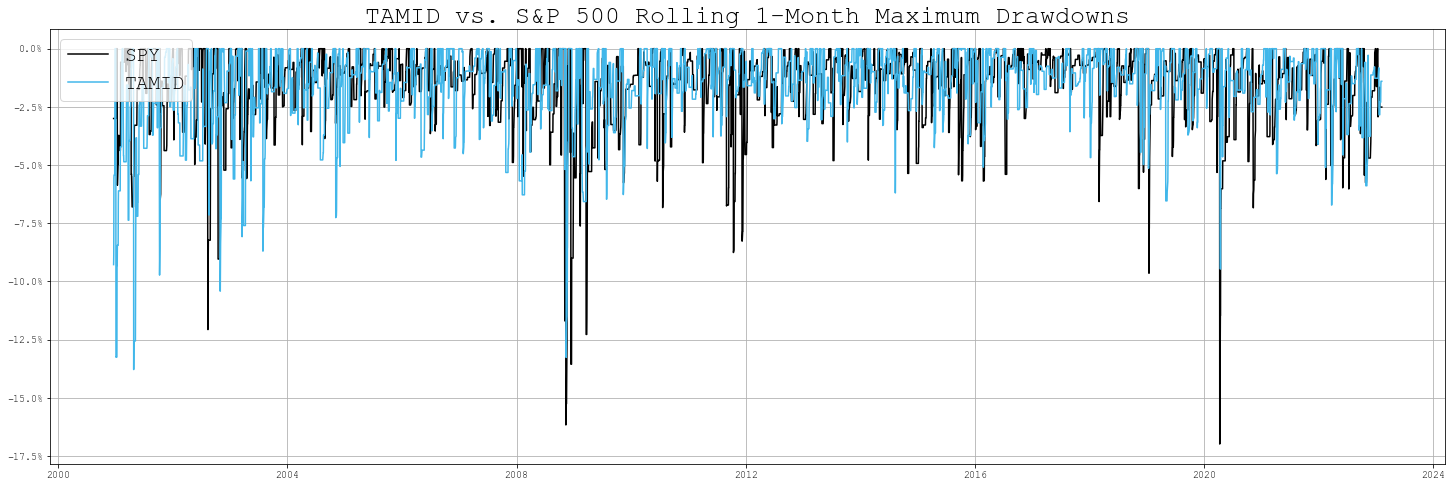

In [52]:
# Create a figure and subplots
import matplotlib as mpl
mpl.rcParams['font.family'] = 'Courier New'

fig, ax1 = plt.subplots(1, figsize=(25, 8))
# Increase the space between subplots
fig.subplots_adjust(hspace=.25)

tamid_color = '#41B7EA'
# ------------------------------------------ Plot Trailing 2-Week Returns ------------------------------------------ 
# Add gridlines
ax1.grid()
# Set the 1st subplot's title
ax1.set_title("TAMID vs. S&P 500 Trailing 2-Week Cumulative Returns", size=25)
# Plot each series individually
ax1.plot(backtest.cumulative_returns(weighted_returns.tail(10)), color=tamid_color, label=weighted_returns.name)
ax1.plot(backtest.cumulative_returns(spy_returns.tail(10)), color='Black', label=spy_returns.name)
ax1.yaxis.set_major_formatter(mtick.PercentFormatter(1))
ax1.legend(loc='upper left',  prop={'size': 20})


fig, ax2 = plt.subplots(1, figsize=(25, 8))
# ------------------------------------------ Plot Trailing 2-Week Sharpe Ratios Bar Chart Analysis ------------------------------------------ 
# Set the 2nd subplot's title
ax2.set_title("Portfolio Holdings' Trailing 2-Week Sharpe Ratios", size=25)
ax2.bar(portfolio_performance['Sharpe Ratio'].index, portfolio_performance['Sharpe Ratio'], color=tamid_color)


fig, ax3 = plt.subplots(1, figsize=(25, 8))
# ------------------------------------------ Plot Returns ------------------------------------------ 
# Add gridlines
ax3.grid()
# Set the 1st subplot's title
ax3.set_title("TAMID vs. S&P 500 Trailing Full-Sample Cumulative Returns", size=25)
# Plot each series individually
ax3.plot(reg_pred, color='Grey', label=reg_pred.name, linestyle='dashed')
ax3.plot(backtest.cumulative_returns(weighted_returns), color=tamid_color, label=weighted_returns.name)
ax3.plot(backtest.cumulative_returns(spy_returns), color='Black', label=spy_returns.name)
ax3.yaxis.set_major_formatter(mtick.PercentFormatter(1))
ax3.legend(loc='upper left',  prop={'size': 20})


fig, ax4 = plt.subplots(1, figsize=(25, 8))
# ------------------------------------------ Plot Rolling 1-Month Sharpe Ratios ------------------------------------------ 
# Add gridlines
ax4.grid()
# Set the 1st subplot's title
ax4.set_title("TAMID vs. S&P 500 Rolling 1-Month Sharpe Ratios", size=25)
# Plot each series individually
ax4.plot(rolling_spy_sr, color='Black', label='SPY')
ax4.plot(rolling_tamid_sr, color=tamid_color, label='TAMID')
ax4.legend(loc='upper left', prop={'size': 20})

fig, ax5 = plt.subplots(1, figsize=(25, 8))
# ------------------------------------------ Plot Rolling 1-Month Sharpe Ratios ------------------------------------------ 
# Add gridlines
ax5.grid()
# Set the 1st subplot's title
ax5.set_title("TAMID vs. S&P 500 Rolling 1-Month Compund Annual Growth Rate (CAGR)", size=25)
# Plot each series individually
ax5.plot(rolling_spy_cagr, color='Black', label='SPY')
ax5.plot(rolling_tamid_cagr, color=tamid_color, label='TAMID')
ax5.yaxis.set_major_formatter(mtick.PercentFormatter(1)) 
ax5.legend(loc='upper left', prop={'size': 20})

fig, ax6 = plt.subplots(1, figsize=(25, 8))
# ------------------------------------------ Plot Rolling 1-Month Max Drawdowns ------------------------------------------ 
# Add gridlines
ax6.grid()
# Set the 1st subplot's title
ax6.set_title("TAMID vs. S&P 500 Rolling 1-Month Maximum Drawdowns", size=25)
# Plot each series individually
ax6.plot(rolling_spy_max_dd, color='Black', label='SPY')
ax6.plot(rolling_tamid_max_dd, color=tamid_color, label='TAMID')
ax6.yaxis.set_major_formatter(mtick.PercentFormatter(1)) 
ax6.legend(loc='upper left', prop={'size': 20})